In [73]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
from torchvision.datasets import MNIST
import numpy as np

device = 'cuda'
## parameters
learning_rate = 0.01
max_epoch = 10
batch_size = 100

In [74]:
download_root = './MNIST_data'
mnistTrain = MNIST(download_root, train=True, download=True, transform=transforms.ToTensor())
mnistTest = MNIST(download_root, train=False, download=True, transform=transforms.ToTensor())

data_loader = torch.utils.data.DataLoader(dataset=mnistTrain,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

##
# CNN Model (2 conv layers)
class CNN(torch.nn.Module):

    def __init__(self, ch1, ch2):
        super(CNN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, ch1, kernel_size=3, stride=1, padding=1, bias=True),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(ch1, ch2, kernel_size=3, stride=1, padding=1, bias=True),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = torch.nn.Linear(7*7*ch2, 10, bias=True)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc(out)
        return out

##
model = CNN(10,20).to(device)

# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
# criterion을 통해 크로스엔트로피를 계산하는데, Softmax가 자동으로 계산되므로 fc layer에서 softmax를 쓰면 안된다
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
## train
total_batch = len(data_loader)

accu_b, loss_b = np.zeros([max_epoch*total_batch]), np.zeros([max_epoch*total_batch])
accu, loss = np.zeros([max_epoch]), np.zeros([max_epoch])
test_a_b = np.zeros([max_epoch*total_batch])
test_a = np.zeros([max_epoch])
for epoch in range(max_epoch):
    avg_cost = 0.0
    k = 0
    for inp, ans in data_loader:
        inp = inp.to(device)
        ans = ans.to(device)

        optimizer.zero_grad()
        y = model(inp)
        cost = criterion(y, ans)
        cost.backward()
        optimizer.step()
        # 학습 끝, 이제 정확도/로스 계산
        # 계산편의를 위해 numpy행렬 변환
        np_ans = ans.cpu().detach().numpy()
        np_y = y.cpu().detach().numpy()
        for i in range(len(np_y)):
            index = np.where(np_y[i,:] == np_y[i,:].max())
            if np_ans[i] == np.asarray(index).max():
                accu_b[(epoch * total_batch) + k] += 1

        # test data에 대해 모든 배치마다 정확도판단 - 오래걸리므로 그래프 그릴때만
        
        with torch.no_grad():
            model.eval()
            X_test = mnistTest.data.view(len(mnistTest), 1, 28, 28).float().to(device)
            Y_test = mnistTest.targets.to(device)
            y_t = model(X_test)
            correct_prediction = torch.argmax(y_t, 1) == Y_test
            accuracy = correct_prediction.float().mean()
            test_a_b[(epoch * total_batch) + k] = accuracy.cpu().detach().numpy()
        accu_b[(epoch * total_batch) + k] /= i
        loss_b[(epoch*total_batch) + k] = cost
        k += 1
        
    # train data 로스/정확도
    loss[epoch] = np.mean(loss_b[(epoch*total_batch):(epoch*total_batch)+k])
    accu[epoch] = np.mean(accu_b[(epoch * total_batch):(epoch * total_batch) + k])
    # test data에 대한 정확도 삽입
    test_a[epoch] = np.mean(test_a_b[(epoch * total_batch):(epoch * total_batch) + k])
    
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, loss[epoch]))

print('Learning Finished!')

[Epoch:    1] cost = 1.12508562
[Epoch:    2] cost = 0.373680768
[Epoch:    3] cost = 0.299976024
[Epoch:    4] cost = 0.250127253
[Epoch:    5] cost = 0.210158309
[Epoch:    6] cost = 0.178196315
[Epoch:    7] cost = 0.155258058
[Epoch:    8] cost = 0.139260316
[Epoch:    9] cost = 0.12613723
[Epoch:   10] cost = 0.115814816
Learning Finished!


<function matplotlib.pyplot.show(close=None, block=None)>

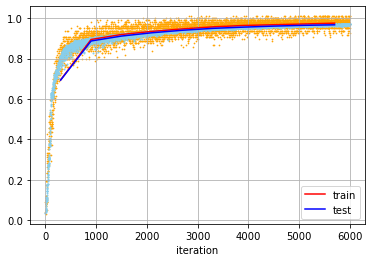

In [75]:
import matplotlib.pyplot as plt
plt.scatter(range(len(accu_b)),accu_b, s=0.5, c='orange')
plt.scatter(range(len(test_a_b)),test_a_b, s=1, c='skyblue')
plt.plot(range(int(total_batch/2), len(accu_b)+1, total_batch),accu, c='red')
plt.plot(range(int(total_batch/2), len(test_a_b)+1, total_batch),test_a, c='blue')
plt.legend(["train", "test"])
plt.xlabel('iteration')
plt.grid(1)
plt.show

# 그래프 그릴 필요 없을 때에는 그냥 바로 최종 정확도만 측정

In [76]:
with torch.no_grad():
    model.eval()
    X_test = mnistTest.data.view(len(mnistTest), 1, 28, 28).float().to(device)
    Y_test = mnistTest.targets.to(device)
    y_t = model(X_test)
    correct_prediction = torch.argmax(y_t, 1) == Y_test
    accuracy = correct_prediction.float().mean()
print(accu[-1]*100, accuracy.cpu().detach().numpy()*100)

97.57912457912458 96.9599962234497


In [77]:
#print(accu[-1]*100, test_a[-1]*100)